In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:03<00:00, 15.04it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 10
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:02<00:00, 11485.80it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [26]:
import tensorflow as tf

# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Ensure TensorFlow uses only the first GPU (change index if necessary)
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

# Perform a simple operation on the GPU
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
    b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
    c = a * b

print("Result (on GPU):", c.numpy())


2023-10-12 09:31:53.029849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Result (on GPU): [5. 8. 9. 8. 5.]


2023-10-12 09:31:53.861907: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    closses=0
    flosses=0
    elosses=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # reshape decoded_x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        decoded_x2 = decoded_x.reshape(21,32, 6)
        # reshape data.x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        data.x2 = data.x.reshape(21,32, 6)
        # calculate chamfer distance between decoded_x and data.x
        # print(decoded_x.shape,data.x.shape)
        # print(decoded_x.device,data.x.device)
        # print(decoded_x.dtype,data.x.dtype)
        # print(decoded_x.requires_grad,data.x.requires_grad)
        closs=chamfer_distance(decoded_x2,data.x2)
        closs=closs[0]
        floss=MSE_loss(decoded_x, data.x)
        loss=floss+closs
        loss.backward()
        all_loss_mse += float(loss)
        closses+=float(closs)
        flosses+=float(floss)
        optimizer.step()
        
    return all_loss_mse/len(train_loader),closses/len(train_loader),flosses/len(train_loader)
   

In [28]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    closses=0
    flosses=0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        decoded_x2 = decoded_x.reshape(21,32, 6)
        data.x2 = data.x.reshape(21,32, 6)
        closs=chamfer_distance(decoded_x2,data.x2)
        closs=closs[0]
        floss=MSE_loss(decoded_x, data.x)
        loss=floss+closs
        all_loss_mse += float(loss)
        closses+=float(closs)
        # loss = MSE_loss(decoded_x, data.x)
        # all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader),closses/len(test_loader),flosses/len(test_loader)

In [29]:
train_losses = []
test_losses = []
closses=[]
flosses=[]
elosses=[]
tclosses=[]
tflosses=[]
if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse,closs,floss = train()
        # train_loss_mse = train()
        test_loss_mse,tcloss,tfloss= test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tFeature Loss: {floss:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f},\tChamfer Loss: {tcloss:.4f},\tFeature Loss: {tfloss:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);
        closses.append([closs])
        flosses.append([floss])
        tclosses.append([tcloss])
        tflosses.append([tfloss])
        

        scheduler.step()
    torch.save(model,"./models/"+model_name)

RuntimeError: Not compiled with GPU support.

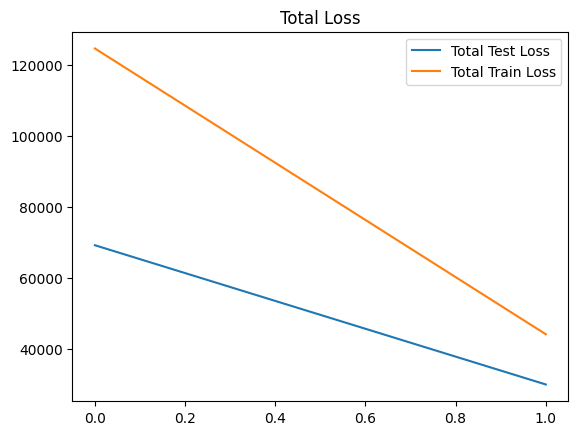

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

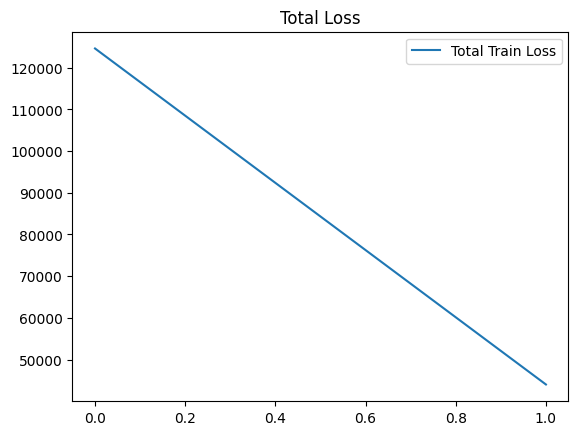

In [ ]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

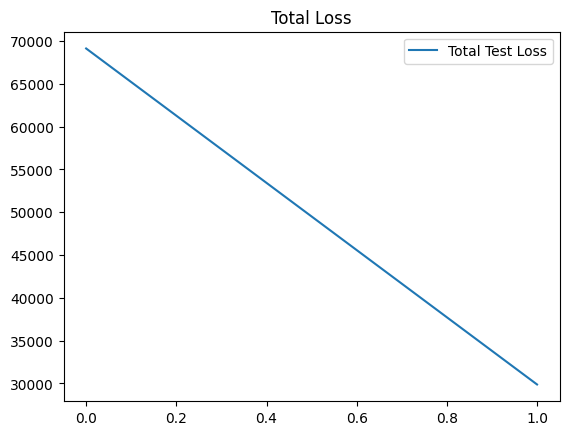

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [ ]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 29340.096270381877


In [ ]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [ ]:
decoded_feature[0][heavy_indices]

tensor([[1839.8823,  -19.5602,  -24.8942,   23.9641,   24.7946,   23.0787],
        [ 669.9647,   -7.1211,   -9.0649,    9.4969,    9.4912,    9.3712],
        [ 632.2067,   -6.7196,   -8.5540,    9.0310,    8.9981,    8.9302],
        [ 698.3547,   -7.4229,   -9.4490,    9.8468,    9.8611,    9.7020],
        [ 696.5813,   -7.4041,   -9.4250,    9.8250,    9.8380,    9.6813],
        [ 681.0227,   -7.2386,   -9.2145,    9.6332,    9.6353,    9.5001],
        [ 689.5779,   -7.3296,   -9.3302,    9.7386,    9.7468,    9.5997],
        [ 619.3924,   -6.5834,   -8.3806,    8.8716,    8.8296,    8.7789],
        [ 589.9096,   -6.2699,   -7.9817,    8.5018,    8.4403,    8.4259],
        [ 620.8822,   -6.5992,   -8.4008,    8.8901,    8.8492,    8.7966],
        [ 669.5966,   -7.1172,   -9.0599,    9.4923,    9.4864,    9.3669],
        [ 664.2034,   -7.0598,   -8.9869,    9.4259,    9.4161,    9.3041],
        [ 627.9891,   -6.6748,   -8.4969,    8.9787,    8.9428,    8.8806],
        [ 59

In [ ]:
input_feature[0][heavy_indices]

tensor([[ 989.7930, -119.8051, -197.3818,    6.7150,   14.1525,   19.4275],
        [ 987.6583, -119.5233, -197.0793,    5.0925,   12.4475,   18.3625],
        [ 989.2891, -119.6960, -197.3463,    5.7025,   16.5350,   20.2575],
        [ 990.1309, -119.8539, -197.4697,    7.1400,   13.6650,   22.0950],
        [ 988.7142, -119.7323, -197.2135,    8.9025,   14.4725,   17.6225],
        [ 989.6954, -119.8333, -197.3915,    7.0275,   12.6350,   16.6325],
        [ 988.8264, -119.6267, -197.3188,    7.0300,   16.6125,   17.1800],
        [ 989.5078, -119.6904, -197.4448,    9.6850,   13.3500,   21.0950],
        [ 989.7481, -119.6539, -197.3629,    4.3725,   15.6300,   16.8900],
        [ 988.3774, -119.5720, -197.1361,    2.6875,   14.7950,   20.4075],
        [ 989.6597, -119.8467, -197.3645,    7.9225,   18.3350,   19.6450],
        [ 990.3069, -119.8805, -197.5004,    5.5350,   11.6625,   23.1500],
        [ 989.9455, -119.7622, -197.4373,   10.7025,   11.5150,   19.8350],
        [ 98

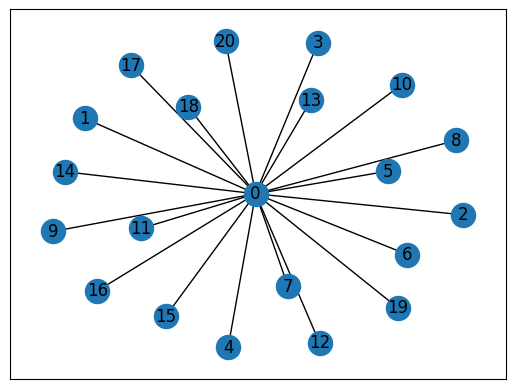

In [ ]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def tryshape():
    m=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # chamfer_distance needs shaped N P D
        # N is number of points
        # P is number of points to compare to
        # D is dimension of each point
        # where N is the number of points in the pointcloud = 4*number of atoms
        # P is the number of points to compare to = 4*number of atoms
        # D is the dimension of each point = 3
        # reshape decoded_x
        # print(decoded_x.shape) - [672,6]
        decoded_x = decoded_x.reshape(21,32,6)
        data.x=data.x.reshape(21,32,6)
        closs=chamfer_distance(decoded_x,data.x)
        closs=closs[0]
        loss=closs
        loss.backward()
        all_loss_mse += float(loss)
        # flosses+=float(floss)
        optimizer.step()

        if(m==0):
            # print(data.x)
            print(decoded_x)
            print(f"Data.shape : {data.x.shape}")
            print(f"Decoded.shape : {decoded_x.shape}")
            print(f"Data[0].shape : {data[0].x.shape}")
            print(f"Data[1].shape : {data[1].x.shape}")
            print(f"Data[2].shape : {data[2].x.shape}")
            print(f"Data[3].shape : {data[3].x.shape}")
            print(f"Data[4].shape : {data[4].x.shape}")
            print(f"Data[5].shape : {data[5].x.shape}")
            print(f"Data[6].shape : {data[6].x.shape}")
            print(f"Data[7].shape : {data[7].x.shape}")
            print(f"Data[8].shape : {data[8].x.shape}")
            print(f"Data[21].shape : {data[21].x.shape}")
            
            print(f"Decoded[0].shape : {decoded_x[0].shape}")
        m+=1
    return all_loss_mse/len(train_loader)
    # return all_loss_mse/len(train_loader),closses/len(train_loader),flosses/len(train_loader),elosses/len(train_loader)

In [ ]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 26530.0683
Epoch: 002
	Train:	MSE Loss: 17182.4104


In [ ]:
tryshape()


tensor([[2118.1438,  -22.5189,  -28.6591,   27.3942,   28.4206,   26.3208],
        [ 745.9501,   -7.9290,  -10.0930,   10.4336,   10.4813,   10.2565],
        [ 699.0690,   -7.4305,   -9.4587,    9.8556,    9.8704,    9.7103],
        ...,
        [ 833.4938,   -8.8598,  -11.2774,   11.5127,   11.6221,   11.2765],
        [ 844.5501,   -8.9774,  -11.4270,   11.6490,   11.7662,   11.4053],
        [ 928.1469,   -9.8662,  -12.5581,   12.6795,   12.8555,   12.3793]],
       device='cuda:0', dtype=torch.float64, grad_fn=<LeakyReluBackward0>)
Data.shape : torch.Size([672, 6])
Decoded.shape : torch.Size([672, 6])
Data[0].shape : torch.Size([21, 6])
Data[1].shape : torch.Size([21, 6])
Data[2].shape : torch.Size([21, 6])
Data[3].shape : torch.Size([21, 6])
Data[4].shape : torch.Size([21, 6])
Data[5].shape : torch.Size([21, 6])
Data[6].shape : torch.Size([21, 6])
Data[7].shape : torch.Size([21, 6])
Data[8].shape : torch.Size([21, 6])
Data[21].shape : torch.Size([21, 6])
Decoded[0].shape : torc

1